In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, evaluate
from surprise import KNNBasic, KNNBaseline
from surprise import Reader
from surprise import accuracy

In [53]:
rating_df=pd.read_csv('ml-20m/ratings.csv')

In [54]:
rating_df=rating_df.drop(['timestamp'],axis=1)

In [42]:
rating_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [45]:
print('maximum number of rating a movie has',max(rating_df['movieId'].value_counts()))
print('minimum number of rating a movie has',min(rating_df['movieId'].value_counts()))

('maximum number of rating a movie has', 67310)
('minimum number of rating a movie has', 1)


In [46]:
print('maximum number of movies a user rated',max(rating_df['userId'].value_counts()))
print('minimum number of movies a user rated',min(rating_df['userId'].value_counts()))

('maximum number of movies a user rated', 9254)
('minimum number of movies a user rated', 20)


### Plot rating distribution

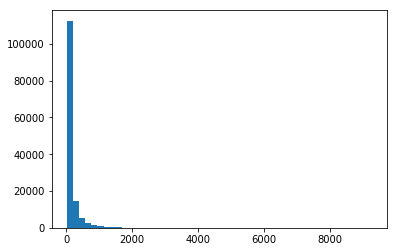

In [47]:
rating_freq=rating_df['userId'].value_counts()
df = pd.DataFrame(rating_freq).reset_index()
df.columns = ['userId', 'count']
plt.hist(df['count'],bins=50)
plt.show()

#### First, we delete those movies that has the number of ratings less than 5.

In [55]:
movieid=rating_df['movieId'].value_counts()
movieid = pd.DataFrame(movieid).reset_index()
movieid.columns = ['movieId', 'count']
movieId_5=movieid.loc[movieid['count']<=5]
rating_del=rating_df.loc[~rating_df['movieId'].isin(movieId_5['movieId'])]

### Since we need to subsample the dataset, we decide to choose up to 10000 users. We choose the number of ratings in different ranges based on the proportion of that range in total dataset.

In [56]:
#rating_del=rating_df
num_user=10000
rating_freq=rating_del['userId'].value_counts()
df = pd.DataFrame(rating_freq).reset_index()
df.columns = ['userId', 'count']
df_50=df.loc[(df['count']<50)&(40<=df['count'])]
use_df_50=df.loc[df['count']<50]
freq_50=len(use_df_50)/float(len(df['count']))
print('frequency_of rate count between 40 and 50',freq_50)

df_50_100=df.loc[(df['count']<100) & (50<=df['count'])]
freq_50_100=len(df_50_100)/float(len(df['count']))
print('frequency_of rate count between 50 and 100',freq_50_100)

df_100_500=df.loc[(df['count']<500) & (100<=df['count'])]
freq_100_500=len(df_100_500)/float(len(df['count']))
print('frequency_of rate count between 100 and 500',freq_100_500)

df_500_1000=df.loc[(df['count']<1000) & (500<=df['count'])]
freq_500_1000=len(df_500_1000)/float(len(df['count']))
print('frequency_of rate count between 500 and 1000',freq_500_1000)

df_1000=df.loc[1000<=df['count']]
freq_1000=len(df_1000)/float(len(df['count']))
print('frequency_of rate count larger than 1000',freq_1000)

df_trimmed_50=df_50.sample(n = int(num_user*freq_50))
df_trimmed_50_100=df_50_100.sample(n = int(num_user*freq_50_100))
df_trimmed_100_500=df_100_500.sample(n = int(num_user*freq_100_500))
df_trimmed_500_1000=df_500_1000.sample(n = int(num_user*freq_500_1000))
df_trimmed_1000=df_1000.sample(n = int(num_user*freq_1000))
rating_50=rating_del.loc[rating_del['userId'].isin(df_trimmed_50['userId'])]
rating_50_100=rating_del.loc[rating_del['userId'].isin(df_trimmed_50_100['userId'])]
rating_100_500=rating_del.loc[rating_del['userId'].isin(df_trimmed_100_500['userId'])]
rating_500_1000=rating_del.loc[rating_del['userId'].isin(df_trimmed_500_1000['userId'])]
rating_1000=rating_del.loc[rating_del['userId'].isin(df_trimmed_1000['userId'])]
result = pd.concat([rating_50, rating_50_100,rating_100_500,rating_500_1000,rating_1000], axis=0, sort=False)

('frequency_of rate count between 40 and 50', 0.3841710411356531)
('frequency_of rate count between 50 and 100', 0.2361057959608067)
('frequency_of rate count between 100 and 500', 0.32567711003444216)
('frequency_of rate count between 500 and 1000', 0.04044247723711668)
('frequency_of rate count larger than 1000', 0.0136035756319814)


#### We also want to eliminate the number of minimum ratings a movie has, so we decide to delete those movies which have total number of ratings less than 20.

In [89]:
movieid=result['movieId'].value_counts()
movieid = pd.DataFrame(movieid).reset_index()
movieid.columns = ['movieId', 'count']
movieId_5=movieid.loc[movieid['count']<=20]
final_df=result.loc[~result['movieId'].isin(movieId_5['movieId'])]

In [36]:
import random

#### Then we randomly choose 3000 different movies in our current dataset.

In [90]:
random.seed(10)
movieid_count=final_df['movieId'].value_counts().reset_index()
use_movieid=random.sample(movieid_count['index'], 3000)
final_df_2=final_df.loc[final_df['movieId'].isin(use_movieid)]

### we reindex the movieId and userId so the index starts from 1.

In [91]:
ratings=final_df_2

In [92]:
ratings['Rank'] = ratings.userId.rank(method='dense').astype(int)
ratings['userId']=ratings['Rank']
ratings=ratings.drop(['Rank'],axis=1)
ratings['Rank'] = ratings.movieId.rank(method='dense').astype(int)
ratings['movieId']=ratings['Rank']
ratings=ratings.drop(['Rank'],axis=1)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [93]:
ratings=ratings.reset_index()
ratings=ratings.drop(['index'],axis=1)

In [64]:
ratings.head()

,userId,movieId,rating
0,3,8,3.0
1,3,16,4.0
2,3,51,2.0
3,3,56,3.0
4,3,59,2.0


#### Let's check the current distribution of dataset.

In [65]:
print('maximum number of rating a movie has',max(ratings['movieId'].value_counts()))
print('minimum number of rating a movie has',min(ratings['movieId'].value_counts()))

('maximum number of rating a movie has', 5225)
('minimum number of rating a movie has', 21)


In [66]:
print('maximum number of movies a user rated',max(ratings['userId'].value_counts()))
print('minimum number of movies a user rated',min(ratings['userId'].value_counts()))

('maximum number of movies a user rated', 1497)
('minimum number of movies a user rated', 8)


In [76]:
len(ratings['userId'].value_counts())

9998

In [77]:
len(ratings['movieId'].value_counts())

3000

#### We have 9998 users and 3000 movies

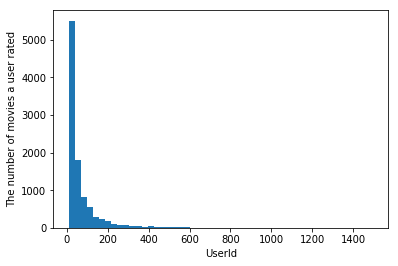

In [72]:
rating_freq_user=ratings['userId'].value_counts()
df = pd.DataFrame(rating_freq_user).reset_index()
df.columns = ['userId', 'count']
plt.hist(df['count'],bins=50)
plt.xlabel('UserId')
plt.ylabel('The number of movies a user rated')
plt.savefig('User.jpg')
plt.show()

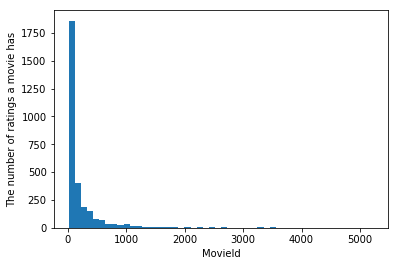

In [71]:
rating_freq_user=ratings['movieId'].value_counts()
df = pd.DataFrame(rating_freq_user).reset_index()
df.columns = ['userId', 'count']
plt.hist(df['count'],bins=50)
plt.xlabel('MovieId')
plt.ylabel('The number of ratings a movie has')
plt.savefig('movie.jpg')
plt.show()

#### we can see that the distribution of the number of movies a user rated is similar with the original dataset, so we preserve this distribution 

In [38]:
ratings.to_csv('subsample_data_3.csv',index=False)

In [78]:
print('minimum_rating',min(ratings['rating']))
print('maximum_rating',max(ratings['rating']))

('minimum_rating', 0.5)
('maximum_rating', 5.0)


In [84]:
from sklearn.model_selection import train_test_split

In [94]:
train, test= train_test_split(ratings, test_size=0.2, random_state=42)

In [96]:
train.to_csv('train_data.csv',index=False)
test.to_csv('test_data.csv',index=False)